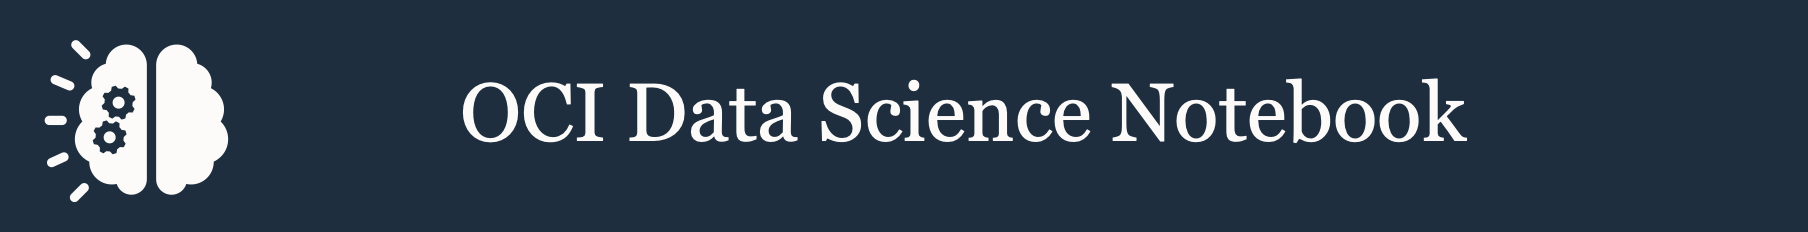

</br><h2 style='color:#005EB8'>ML Flow - Using OCI Tracking Server with Auth Enabled and Object Storage & MySQL Backend</h2>

**<span style='color:#005EB8'>Author:**</span> Ismail Syed</br>
**<span style='color:#005EB8'>Title:**</span> Senior Data Scientist EMEA</br>
**<span style='color:#005EB8'>Company:**</span> Oracle

<span style='color:#005EB8'>**Notebook Description:**</span> In this Notebook we will look at how we can use the `oci-mlflow` library to save our models and model experiment data to our OCI MLFlow Tracking Server while using MLFlow Authentication and an OCI Object Storage & MySQL Backend for storing artifacts and experiemnts data.</br></br> <span style='color:#005EB8'>**NOTE:**</span> This sample code is intended for tutorial purposes only.</br>

The data set used in this example is from http://archive.ics.uci.edu/ml/datasets/Wine+Quality
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.
</br>

</br><h3 style='color:#005EB8'>Imports</h3>

In [ ]:
import logging
import os
import sys
import warnings
from urllib.parse import urlparse

import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

</br><h3 style='color:#005EB8'>Establish Connection to Tracking Server</h3>

In [ ]:
# Define Username and Password as ENV Variables
os.environ['MLFLOW_TRACKING_USERNAME'] = 'admin'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'password'

In [ ]:
# Point to OCI Tracking Server Container
mlflow.set_tracking_uri("http://<mlflow-tracking-server-ip>:<mlflow-tracking-server-port>")

</br><h3 style='color:#005EB8'>Load Data</h3>

In [ ]:
# Set Numpy Random See
np.random.seed(40)

# Define Datset URL
csv_url = ("https://raw.githubusercontent.com/mlflow/mlflow/master/tests/datasets/winequality-red.csv")

# Read the wine-quality csv file from the URL
try:
    data = pd.read_csv(csv_url, sep=";")
except Exception as e:
    logger.exception(
        "Unable to download training & test CSV, check your internet connection. Error: %s", e
    )

# Split the data into training and test set
train, test = train_test_split(data)

# The predicted column is "quality" which is a scalar from [3, 9]
train_x = train.drop(["quality"], axis=1)
test_x = test.drop(["quality"], axis=1)
train_y = train[["quality"]]
test_y = test[["quality"]]

In [ ]:
# Preview Data
train_x.head()

</br><h3 style='color:#005EB8'>Define Evaluation Metrics</h3>

In [ ]:
# Function to Calculate Evaluation Metrics
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

</br><h3 style='color:#005EB8'>Define Model Building Job</h3>

In [ ]:
def train_lr_model(alpha, l1_ratio): 

    # Set Hyperparameters
    alpha = alpha
    l1_ratio = l1_ratio

    # Start ML Flow Run
    with mlflow.start_run():
        
        # Instantiate and train Linear Regression Model
        lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
        lr.fit(train_x, train_y)

        # Make predictions on test set
        predicted_qualities = lr.predict(test_x)

        # Calculate Evaluation Metrics
        (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

        # Print Hyperparameters and Eval Metrics
        print(f"Elasticnet model (alpha={alpha:f}, l1_ratio={l1_ratio:f}):")
        print(f"  RMSE: {rmse}")
        print(f"  MAE: {mae}")
        print(f"  R2: {r2}")

        # Log Evaluation Metrics to ML Flow Tracking Server
        mlflow.log_param("alpha", alpha)
        mlflow.log_param("l1_ratio", l1_ratio)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        # Make predictions on Train Set
        predictions = lr.predict(train_x)
        signature = infer_signature(train_x, predictions)

        # Get MLFlow Tracking Server
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Register Model to Tracking Server or Save Locally
        if tracking_url_type_store != "file":
            # Register the model
            mlflow.sklearn.log_model(lr, "model", registered_model_name="ElasticnetWineModel", signature=signature)
        else:
            mlflow.sklearn.log_model(lr, "model", signature=signature)


</br><h3 style='color:#005EB8'>Run Experiments</h3>

In [ ]:
# Run Experiment 1
train_lr_model(0.5, 0.5)

In [ ]:
# Run Experiment 2
train_lr_model(0.4, 0.4)

In [ ]:
# Run Experiment 3
train_lr_model(0.3, 0.2)

In [ ]:
# Run Experiment 4
train_lr_model(0.2, 0.3)

In [ ]:
# Run Experiment 5
train_lr_model(0.1, 0.1)

</br><h3 style='color:#005EB8'>Load Registered Model & Make Predictions</h3>

In [ ]:
# Tracking Server Model ID
logged_model = '<mlflow-stored-model-id>'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
new_preds = loaded_model.predict(test_x)

new_preds[0:10]

</br></br><center><h1 style='color:#005EB8'>End of Notebook</h1></center>